Use the reservoir that is learnt to predict just the next time step. See what the prediction is, and based on the difference, apply control input.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

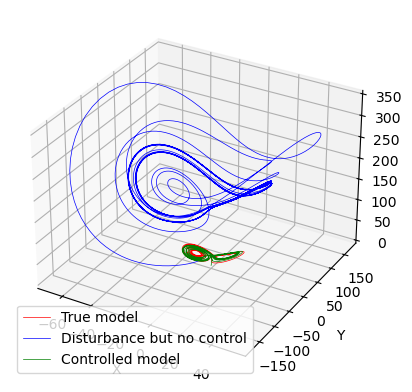

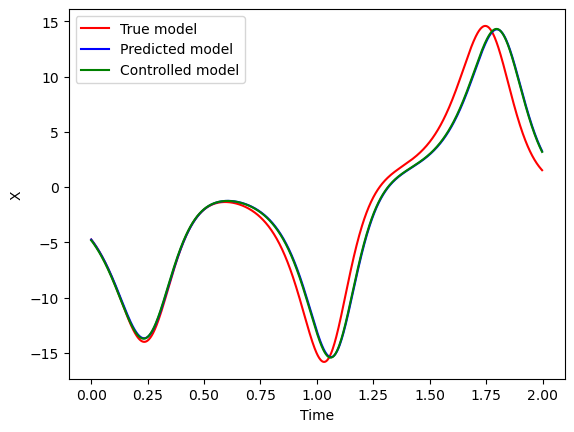

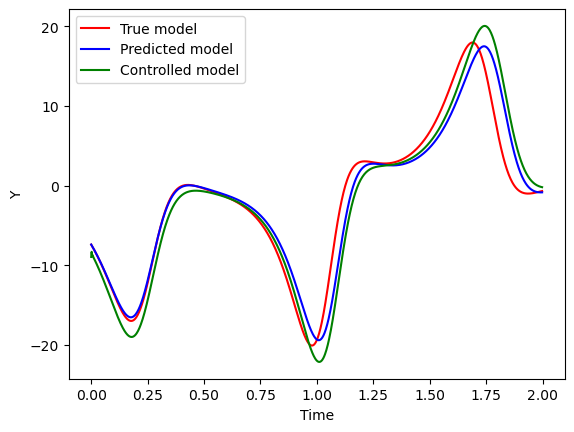

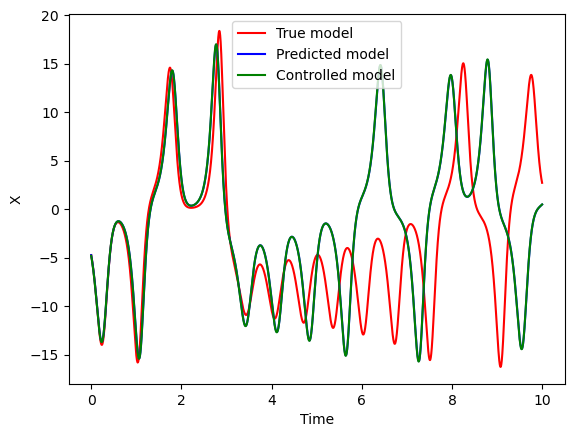

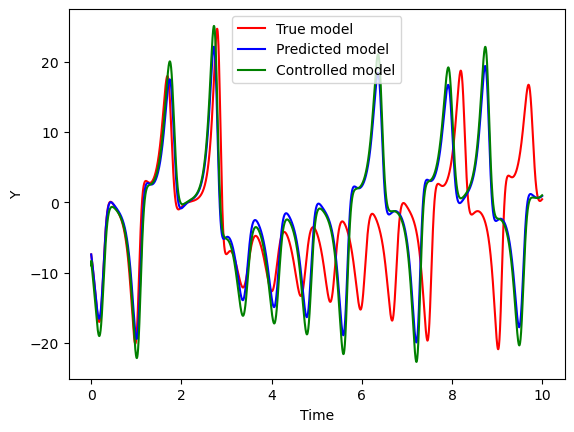

In [13]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 150
controlgain = 1.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xxtrack - xxpid)
    yypid += dt * yypidp + controlgain * (yytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (zztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], xpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plottimerange = np.arange(0, 1000)



# plt.figure()
# plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
# plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
# plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()




# plt.figure()
# plt.plot(testingtimes[100:200], ypure[100:200], 'r', label = 'True model')
# plt.plot(testingtimes[100:200], ynocontrol[100:200],  'g', label = 'Disturbed model')
# plt.legend()
# plt.show()

So there are two clear problems here. One is, the forecasting is only good for a few seconds. Can't do much for much longer.

Maybe get a statistical relation between the parameters and the time for which the forecasting would be good for.

Wait, if the Win and A matrices are fixed, why not just use the same reservoir for finding different Wout matrices for detecting disturbance and to detect the model. 

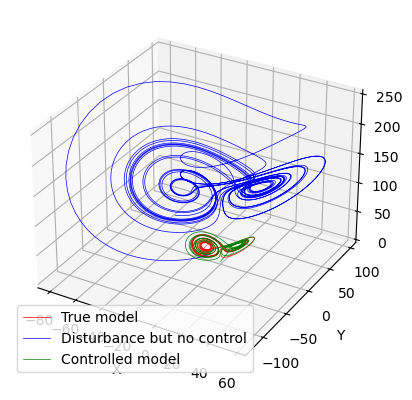

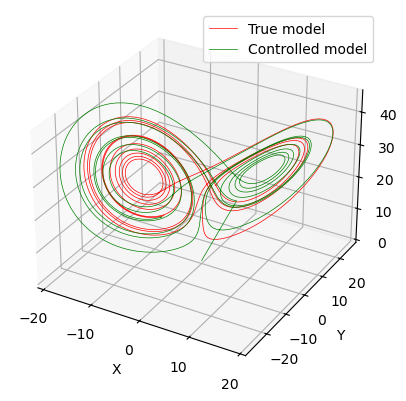

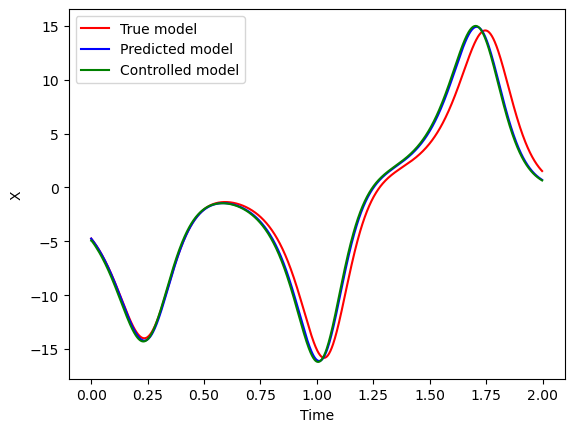

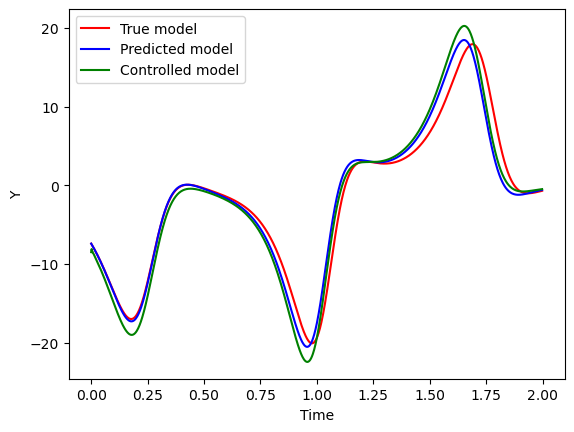

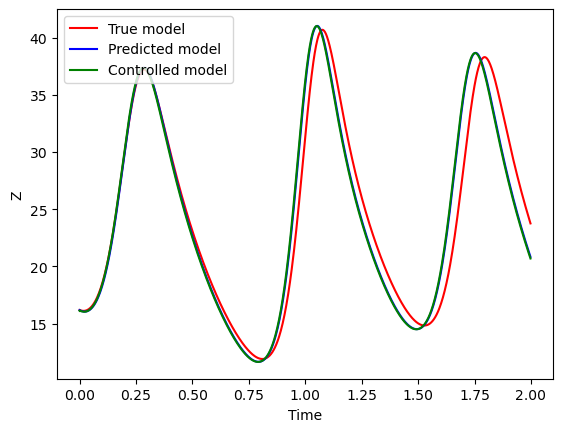

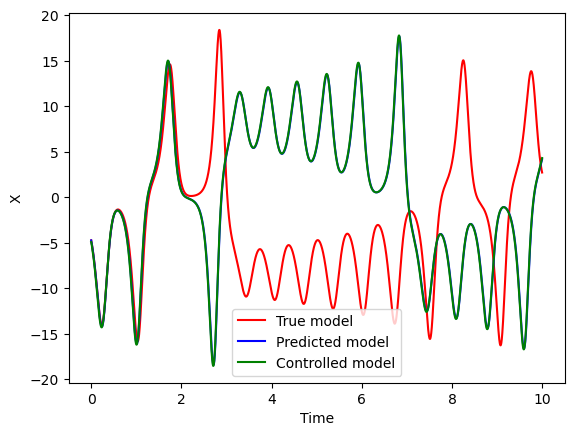

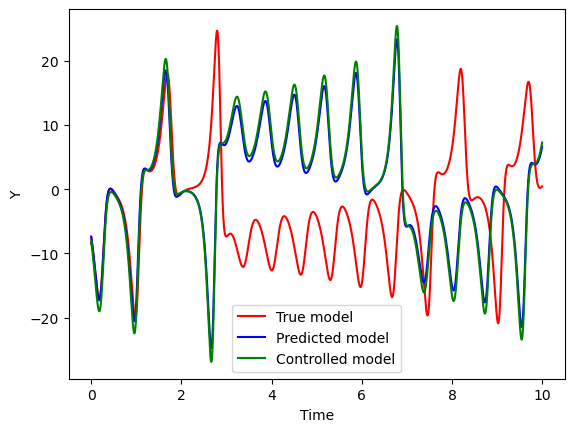

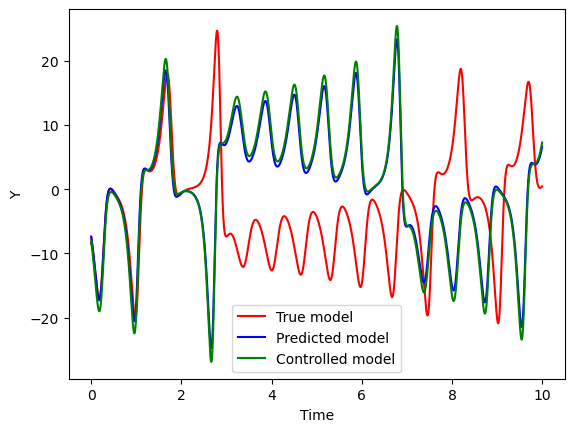

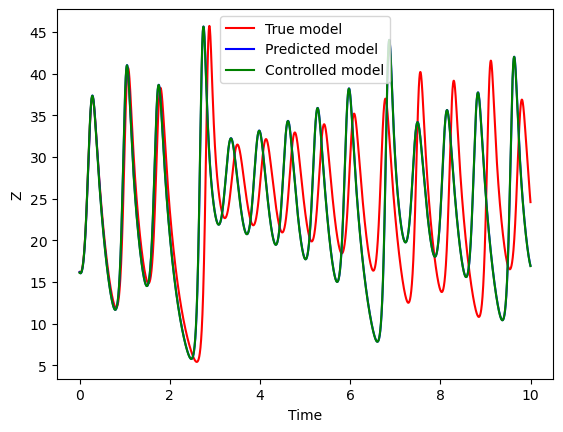

In [6]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
delsigma = 20
delrho = 100
delbeta = 1
controlgain = 1.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = (sigma + delsigma) * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * ((rho + delrho) - zznocontrol) - yynocontrol
    zznocontrolp = xxnocontrol * yynocontrol - (beta + delbeta) * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    xxpidp = (sigma + delsigma) * (yypid - xxpid)
    yypidp = xxpid * ((rho + delrho) - zzpid) - yypid 
    zzpidp = xxpid * yypid - (beta + delbeta) * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xxtrack - xxpid)
    yypid += dt * yypidp + controlgain * (yytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (zztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ztrack[plottimerange],  'b', label = 'Predicted model')
plt.plot(testingtimes[plottimerange], zpid[plottimerange],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], xpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], zpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ztrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], zpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z')
plt.show()






Works great even without the Ki term.

But I could a Ki term here just to see and compare. See if evaluation changes.